# Descripción general.

- Notebook original: [PyTorch Resnet18 [0.93]](https://www.kaggle.com/code/vincentmaladiere/pytorch-resnet18-0-93)
- Dataset Original (no funciona la descarga): [Planet: Understanding the Amazon from Space](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/overview)
- Dataset para usar en esta notebook: [Planet jpg](https://drive.google.com/file/d/1GrH9ycKbOZW8L3Q4ltjf8KOcCqUysqny/view?usp=sharing)

El concurso es una colaboración entre Planet y SCCON para usar imágenes satelitales en la vigilancia de deforestación y cambio climático, buscando un clasificador que identifique intervenciones en el Amazonas.

El proyecto es crucial para difundir conocimientos en visión por computadora aplicada a la silvicultura y expandir estas técnicas a otros escenarios de monitoreo forestal. Hay escasez de datos e IA en este campo y se necesita un catálogo amplio para entender la biodiversidad, lo cual también atraerá a más empresas interesadas en la protección forestal.

La cantidad de imágenes etiquetadas en este desafío es limitada (alrededor de 40.000), por lo que debemos volver a entrenar los modelos existentes en este pequeño conjunto de datos de Planet. Resnet ha demostrado ser un fuerte candidato en desafíos anteriores entre modelos previamente entrenados como VGG, Inception y DenseNet (lista completa de modelos de torchvision previamente entrenados aquí). Están surgiendo nuevas técnicas de aprendizaje profundo y las ideas que vale la pena explorar incluyen las siguientes:

- [Cossim CNN](https://www.rpisoni.dev/posts/cossim-convolution/) 
- [Vision Transformers](https://github.com/lucidrains/vit-pytorch) 
- [Self-supervised learning](https://docs.lightly.ai/tutorials/package/tutorial_simsiam_esa.html) 

Este conjunto de datos inicialmente contenía imágenes satelitales de 4 bandas —R, G, B e Infrarrojo Cercano (NIR)—, disponibles para descarga a través de torrent. Parece que los torrents han sido desactivados pero, afortunadamente, un usuario de Kaggle ha guardado [todo el conjunto de datos .png RGB](https://www.kaggle.com/nikitarom/planets-dataset). Sin embargo, los archivos .tif que contienen el conjunto de datos NIR ya no están disponibles. El NIR es especialmente útil para calcular índices de verdor como el NDVI. Permite una visualización más detallada del dosel arbóreo y la medición de la absorción de carbono, aunque necesitaríamos recrear un modelo desde cero para usarlo, ya que todos los modelos han sido preentrenados solo con RGB.

El conjunto de datos presenta un gran desequilibrio de clases, con presencia de bosque primario en más del 90% de las etiquetas, mientras que la minería convencional solo representa el 0.25%. Necesitamos monitorear los puntajes para estas clases raras, ya que son la clave para obtener un buen puntaje general y un modelo eficiente para detectar actividades humanas puntuales.

## Configuración de librerías

In [1]:
import os
import random
from time import time
from glob import glob
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from collections import Counter
import dill as pickle

from plotly import graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots


import cv2

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import fbeta_score, confusion_matrix

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as T, models
from torchvision.models.resnet import ResNet18_Weights
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
#!pip install -q torchsummary --user
from torchsummary import summary

from matplotlib import pyplot as plt
%matplotlib inline


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {device}")

device: cuda


Establecemos una semilla aleatoria para fines de reproducibilidad.

In [ ]:
random.seed(101)
np.random.seed(101)
torch.manual_seed(101);

## Exploración de datos

#### Distribución de Etiquetas
Primero carguemos el conjunto de datos de entrenamiento y cuantifiquemos la distribución de las etiquetas.

In [3]:
path = "data"
path_train = os.path.join(path, "train-jpg")
path_test = os.path.join(path, "test-jpg")
print(
    f"train files: {len(os.listdir(path_train))}, "
    f"test files: {len(os.listdir(path_test))}"
)

train files: 40479, test files: 40669


In [4]:
path_class = os.path.join(path, "train_classes.csv")
df = pd.read_csv(path_class)
print(df.shape)
df.head()

(40479, 2)


,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


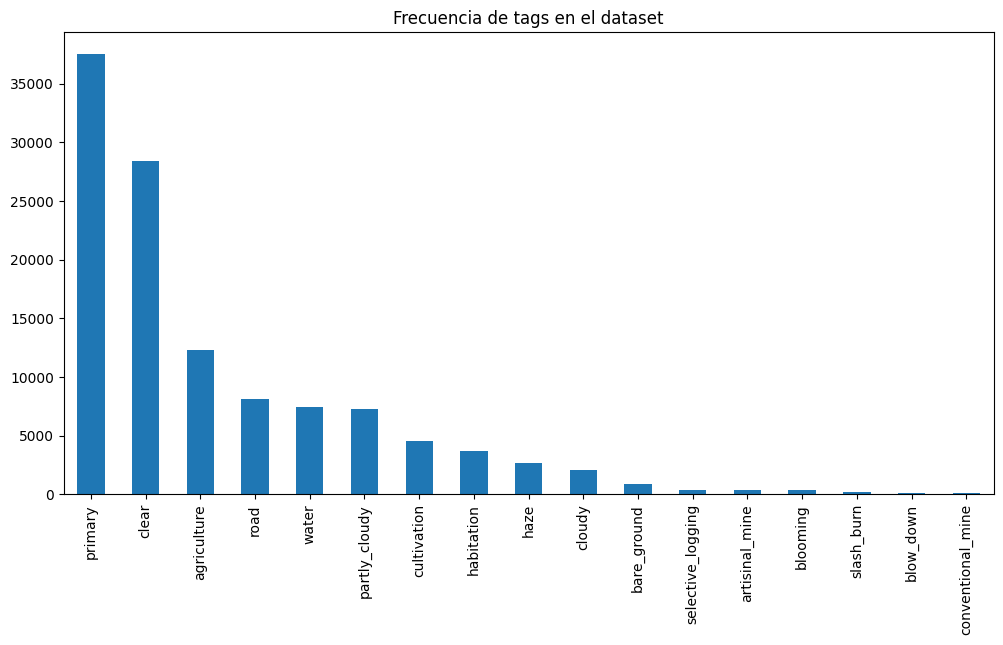

In [5]:
import matplotlib.pyplot as plt

# contare los valores individuales de la columna tags, dividiendola por espacios
tags = df['tags'].str.split(' ', expand=True).stack().value_counts()
tags

# graficar los valores
tags.plot(kind='bar', figsize=(12, 6), title='Frecuencia de tags en el dataset')
plt.show()



In [7]:
df

,image_name,tags,list_tags
0,train_0,haze primary,"[haze, primary]"
1,train_1,agriculture clear primary water,"[agriculture, clear, primary, water]"
2,train_2,clear primary,"[clear, primary]"
3,train_3,clear primary,"[clear, primary]"
4,train_4,agriculture clear habitation primary road,"[agriculture, clear, habitation, primary, road]"
...,...,...,...
40474,train_40474,clear primary,"[clear, primary]"
40475,train_40475,cloudy,[cloudy]
40476,train_40476,agriculture clear primary,"[agriculture, clear, primary]"
40477,train_40477,agriculture clear primary road,"[agriculture, clear, primary, road]"


In [ ]:
df["list_tags"] = df.tags.str.split(" ") # convertir la columna tags en una lista de tags

Como se esperaba, algunas clases están ampliamente representadas mientras que otras apenas están presentes en este conjunto de datos, siguiendo una distribución tipo Pareto. Existe un riesgo importante de que nuestro modelo apenas aprenda las clases raras o incluso las excluya de los datos de entrenamiento al dividir entre los conjuntos de entrenamiento y validación. Identificamos claramente estas clases para una investigación posterior.

## Entrenamiento del Modelo

#### Transformaciones
Para un rendimiento óptimo, [resnet18 necesita formas de entrada que sean múltiplos de 32](https://discuss.pytorch.org/t/input-image-shape-for-resnet18-architecture/80693)  y, en nuestro caso, tenemos entradas de tamaño 256. A partir de 256, el múltiplo más cercano de 32 es 224.

Por lo tanto, reescalamos nuestros datos de entrada usando este múltiplo y también normalizamos nuestro conjunto de datos basándonos en los valores de intensidad media y desviación estándar preentrenados de resnet. ToTensor() es útil para normalizar los valores de nuestras imágenes del rango 0-255 al rango 0-1.

In [9]:
def get_transforms():
    transform_train = T.Compose([
      T.ToPILImage(),
      T.Resize(224),
      T.ToTensor(),
      T.Normalize(
          mean=[0.485, 0.456, 0.406],
          std=[0.229, 0.224, 0.225],
      )
    ])
    transform_val = T.Compose([
      T.ToPILImage(),
      T.Resize(224),
      T.ToTensor(),
      T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
      )
    ])
    return transform_train, transform_val

Definimos nuestra clase Dataset personalizada para manipular lotes de datos entre la RAM y el Disco más fácilmente. Algunos puntos de atención:

* \__init\__: pasamos el dataframe junto con el objetivo, la transformación, la ruta del archivo y el indicador `is_train`. Es importante distinguir entre la fase de entrenamiento y la fase de prueba porque utilizamos aumento de prueba (Test Time Augmentation, TTA).
El aumento durante la prueba (TTA) es útil para diversificar nuestro conjunto de datos de entrenamiento y construir un modelo más robusto. Se aplica en cada imagen para cada lote, lo que significa que no aumenta la longitud de nuestro conjunto de datos de entrenamiento per se, sino que transforma cada imagen aleatoriamente durante el tiempo de ejecución.
* \__getitem\__: definimos qué devuelve el conjunto de datos en cada iteración. Necesita cargar tanto la imagen como el objetivo.
* *collate_fn*: utilizamos esta función dentro de la instancia de DataLoader siguiente. Corresponde a la manipulación del lote. Aquí es donde se llama a transform. También procedemos al aumento de entrenamiento y prueba allí.

In [10]:
class AmazonDatasetError(Exception):
    pass


class AmazonDataset(Dataset):
    def __init__(self, df, ohe_tags, transform, path, is_train=True, idx_tta=None):
        super().__init__()
        self.df = df
        self.ohe_tags = ohe_tags
        self.transform = transform
        if isinstance(path, str):
            self.paths = [path]
        elif isinstance(path, (list, tuple)):
            self.paths = path
        else:
            raise AmazonDatasetError(f"Path type must be str, list or tuple, got: {type(path)}")
        self.is_train = is_train
        if not is_train:
            if not idx_tta in list(range(6)):
                raise AmazonDatasetError(
                    f"In test mode, 'idx_tta' must be an int belonging to [0, 5], got: {repr(idx_tta)}"
                )
            self.idx_tta = idx_tta

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        filename = self.df.iloc[idx].image_name + ".jpg"
        for path in self.paths:
            if filename in os.listdir(path):
                file_path = os.path.join(path, filename)
                break
        else:
            raise AmazonDatasetError(f"Can't fetch {filename} among {self.paths}")
        img = cv2.imread(file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label = self.ohe_tags[idx]
        return img, label

    def collate_fn(self, batch):
        imgs, labels = [], []
        for (img, label) in batch:
            img = self.custom_augment(img)
            img = torch.tensor(img)
            img = img.permute(2, 0, 1)
            img = self.transform(img)
            imgs.append(img[None])
            labels.append(label)
        imgs = torch.cat(imgs).float().to(device)
        labels = torch.tensor(labels).float().to(device)
        return imgs, labels

    def load_img(self, idx, ax=None):
        img, ohe_label = self[idx]
        label = self.df.iloc[idx].tags
        title = f"{label} - {ohe_label}"
        if ax is None:
            plt.imshow(img)
            plt.title(title)
        else:
            ax.imshow(img)
            ax.set_title(title)
    
    def custom_augment(self, img):
        """
        Discrete rotation and horizontal flip.
        Random during training and non random during testing for TTA.
        Not implemented in torchvision.transforms, hence this function.
        """
        choice = np.random.randint(0, 6) if self.is_train else self.idx_tta
        if choice == 0:
            # Rotate 90
            img = cv2.rotate(img, rotateCode=cv2.ROTATE_90_CLOCKWISE)
        if choice == 1:
            # Rotate 90 and flip horizontally
            img = cv2.rotate(img, rotateCode=cv2.ROTATE_90_CLOCKWISE)
            img = cv2.flip(img, flipCode=1)
        if choice == 2:
            # Rotate 180
            img = cv2.rotate(img, rotateCode=cv2.ROTATE_180)
        if choice == 3:
            # Rotate 180 and flip horizontally
            img = cv2.rotate(img, rotateCode=cv2.ROTATE_180)
            img = cv2.flip(img, flipCode=1)
        if choice == 4:
            # Rotate 90 counter-clockwise
            img = cv2.rotate(img, rotateCode=cv2.ROTATE_90_COUNTERCLOCKWISE)
        if choice == 5:
            # Rotate 90 counter-clockwise and flip horizontally
            img = cv2.rotate(img, rotateCode=cv2.ROTATE_90_COUNTERCLOCKWISE)
            img = cv2.flip(img, flipCode=1)
        return img

¡Ahora estamos listos para nuestra completa cadena de procesamiento de datos! Primero definimos nuestro codificador de etiquetas objetivo antes de envolver nuestros conjuntos de datos de entrenamiento y validación personalizados dentro de DataLoaders, con un tamaño de lote de 64, que es un buen compromiso entre el uso de RAM y la velocidad en nuestro caso.

In [11]:
def get_data(df_train, df_val):

    encoder = MultiLabelBinarizer()
    ohe_tags_train = encoder.fit_transform(df_train.list_tags.values)
    ohe_tags_val = encoder.transform(df_val.list_tags.values)

    transform_train, transform_val = get_transforms()
    ds_train = AmazonDataset(df_train, ohe_tags_train, transform_train, path=path_train)
    ds_val = AmazonDataset(df_val, ohe_tags_val, transform_val, path=path_train)

    dl_train = DataLoader(
      ds_train,
      batch_size=64,
      shuffle=True,
      collate_fn=ds_train.collate_fn
    )
    dl_val = DataLoader(
      ds_val,
      batch_size=64,
      shuffle=True,
      collate_fn=ds_val.collate_fn
    )

    return ds_train, ds_val, dl_train, dl_val, encoder

Verificación de cordura: esperamos que `imgs` sea un lote de nuestro tamaño de lote elegido (64), con 3 canales y de las dimensiones de imagen elegidas (224x224). Las `labels` también son un lote de nuestro tamaño elegido (64) con 17 clases diferentes.

In [12]:
df_train, df_val = train_test_split(df, test_size=.2)

In [13]:
df_train.head()

,image_name,tags,list_tags
15859,train_15859,clear primary,"[clear, primary]"
12435,train_12435,partly_cloudy primary,"[partly_cloudy, primary]"
36237,train_36237,agriculture clear primary water,"[agriculture, clear, primary, water]"
8194,train_8194,clear primary,"[clear, primary]"
4932,train_4932,agriculture partly_cloudy primary,"[agriculture, partly_cloudy, primary]"


In [14]:
df_val.head()

,image_name,tags,list_tags
20934,train_20934,habitation haze primary water,"[habitation, haze, primary, water]"
9920,train_9920,clear primary,"[clear, primary]"
37881,train_37881,partly_cloudy primary,"[partly_cloudy, primary]"
646,train_646,cloudy,[cloudy]
23567,train_23567,partly_cloudy primary,"[partly_cloudy, primary]"


In [15]:
ds_train, ds_val, dl_train, dl_val, encoder = get_data(df_train, df_val)

In [16]:
imgs, labels = next(iter(dl_train))
imgs.shape, labels.shape

/tmp/ipykernel_127513/512202253.py:51: UserWarning:

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)



(torch.Size([64, 3, 224, 224]), torch.Size([64, 17]))

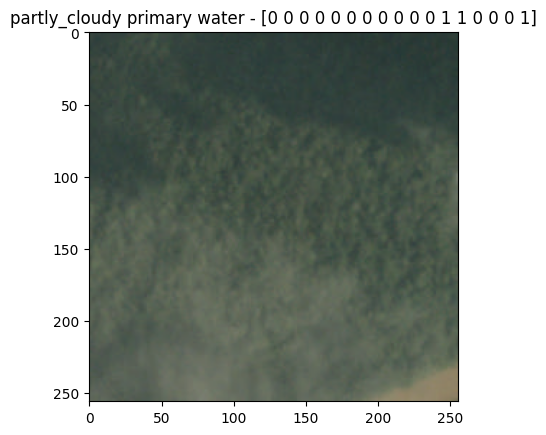

In [17]:
ds_train.load_img(5)

### Definición del modelo

Descargamos pesos directamente del resnet18 previamente entrenado y congelamos todos los pesos. Sobrescribimos la última capa completamente conectada agregando dos capas densas seguidas de un sigmoide. Esta última parte del fc es la única capa a entrenar.

In [18]:
def get_model():
    #model = models.resnet18(pretrained=True)

    # Carga el modelo con los pesos preentrenados utilizando el nuevo sistema
    weights = ResNet18_Weights.DEFAULT
    model = models.resnet18(weights=weights)
    for param in model.parameters():
        param.require_grad = False
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
    model.fc = nn.Sequential(
      nn.Flatten(),
      nn.Linear(512, 128), # 512 for resnet18 or 2048 for resnet 50
      nn.ReLU(inplace=True),
      nn.Dropout(.2),
      nn.Linear(128, 17),
      nn.Sigmoid()
    )
    optimizer = Adam(model.parameters(), lr=1e-4)
    loss_fn = nn.BCELoss()

    return model.to(device), optimizer, loss_fn

## Entrenamiento

In [19]:
def train_batch(X, Y, model, loss_fn, optimizer):
    model.train()
    optimizer.zero_grad()
    Y_hat = model(X)
    batch_loss = loss_fn(Y_hat, Y)
    batch_loss.backward()
    optimizer.step()
    Y_hat = Y_hat.detach().float().cpu().numpy()
    
    return Y_hat, batch_loss.item()


@torch.no_grad()
def compute_val_loss(X, Y, model, loss_fn):
    model.eval()
    Y_hat = model(X)
    batch_loss = loss_fn(Y_hat, Y)
    Y_hat = Y_hat.detach().float().cpu().numpy()
    
    return Y_hat, batch_loss.item()

Elegimos entrenar nuestro modelo durante 21 épocas, mientras reducimos nuestra tasa de aprendizaje en 10 veces cada 7 lotes. Supervisamos la pérdida de validación como nuestra métrica clave. La puntuación de validación es solo útil como indicación secundaria, porque elegimos el umbral de clasificación de manera bastante aleatoria (0.2).
Más adelante, encontraremos el umbral más adaptado para cada objetivo.

In [20]:
def train_model(dl_train, dl_val, idx_fold):
    model, optimizer, loss_fn = get_model()
    lr_scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

    loss_train, loss_val = [], []
    score_train, score_val = [], []

    Y_hat_val = None
    best_loss_val = np.inf

    epochs = 14
    for idx in range(epochs):
        loss_train_epoch, loss_val_epoch = [], []
        Y_hat_train_epoch, Y_hat_val_epoch = [], []
        Y_train_epoch, Y_val_epoch = [], []

        for X, Y in tqdm(dl_train, leave=False):
            Y_hat, batch_loss = train_batch(X, Y, model, loss_fn, optimizer)
            loss_train_epoch.append(batch_loss)
            Y_hat_train_epoch.extend(Y_hat)
            Y_train_epoch.extend(Y.detach().float().cpu().numpy())

        for X, Y in tqdm(dl_val, leave=False):
            Y_hat, batch_loss = compute_val_loss(X, Y, model, loss_fn)
            loss_val_epoch.append(batch_loss)
            Y_hat_val_epoch.extend(Y_hat)
            Y_val_epoch.extend(Y.detach().float().cpu().numpy())
                
        avg_loss_train = np.mean(loss_train_epoch)
        avg_loss_val = np.mean(loss_val_epoch)

        Y_hat_train_epoch = np.array(Y_hat_train_epoch)
        Y_hat_val_epoch = np.array(Y_hat_val_epoch)
        Y_thresh_train_epoch = (Y_hat_train_epoch > .2).astype(float)
        Y_thresh_val_epoch = (Y_hat_val_epoch > .2).astype(float)
        Y_train_epoch = np.array(Y_train_epoch)
        Y_val_epoch = np.array(Y_val_epoch)
        
        score_train_epoch = fbeta_score(Y_train_epoch, Y_thresh_train_epoch, beta=2, average="samples")
        score_val_epoch = fbeta_score(Y_val_epoch, Y_thresh_val_epoch, beta=2, average="samples")
               
        # saving values for debugging
        if avg_loss_val < best_loss_val:
            best_loss_val = avg_loss_val
            Y_hat_val = Y_hat_val_epoch
            Y_thresh_val = Y_thresh_val_epoch
            Y_val = Y_val_epoch
            
        loss_train.append(avg_loss_train)
        loss_val.append(avg_loss_val)
        score_train.append(score_train_epoch)
        score_val.append(score_val_epoch)

        print(
            f"epoch: {idx}/{epochs} -- train loss: {avg_loss_train}, " \
            f"val loss: {avg_loss_val}" \
            f" -- train fbeta_score: {score_train_epoch}, " \
            f"val fbeta_score: {score_val_epoch}"
        )
        
        lr_scheduler.step()

    train_results = {
        "loss_train": loss_train,
        "loss_val": loss_val,
        "score_train": score_train,
        "score_val": score_val,
        "Y_hat_val": Y_hat_val,
        "Y_thresh_val": Y_thresh_val,
        "Y_val": Y_val,
    }
        
    torch.save(model, f"resnet18_fold{idx_fold}.pth")
    pickle.dump(train_results, open(f"train_results_fold{idx_fold}.pkl", "wb"))

Existe el riesgo de que hayamos creado un desequilibrio dentro de nuestras clases raras al dividir aleatoriamente nuestro conjunto de datos entre entrenamiento y validación. Asegurémonos de que la representación de clases raras sea similar en ambos conjuntos de datos.

In [21]:
RARE_CLASSES = [
    "bare_ground", "selective_logging", "artisinal_mine", "blooming", "slash_burn", "blow_down", "conventional_mine"
]

In [22]:
for rare_class in RARE_CLASSES:
    total_train = df_train.loc[df_train.tags.str.contains(rare_class)].shape[0]
    total_val = df_val.loc[df_val.tags.str.contains(rare_class)].shape[0]
    print(f"train {rare_class}: {100 * total_train / df_train.shape[0]:.4f}% ({total_train})")
    print(f"val {rare_class}: {100 * total_val / df_val.shape[0]:.4f}% ({total_val})\n")

train bare_ground: 2.1493% (696)
val bare_ground: 2.0504% (166)

train selective_logging: 0.8708% (282)
val selective_logging: 0.7164% (58)

train artisinal_mine: 0.8399% (272)
val artisinal_mine: 0.8276% (67)

train blooming: 0.8677% (281)
val blooming: 0.6299% (51)

train slash_burn: 0.4941% (160)
val slash_burn: 0.6052% (49)

train blow_down: 0.2316% (75)
val blow_down: 0.2841% (23)

train conventional_mine: 0.2347% (76)
val conventional_mine: 0.2964% (24)



In [23]:
# Esto me tardo en entrenar 150 minutos
train_model(dl_train, dl_val, 0)

  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

epoch: 0/14 -- train loss: 0.1555719474411529, val loss: 0.09931913235290783 -- train fbeta_score: 0.8597068222812374, val fbeta_score: 0.9157351113551595


  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

epoch: 1/14 -- train loss: 0.10365689238864678, val loss: 0.09220771720324915 -- train fbeta_score: 0.9102731124780759, val fbeta_score: 0.9204157900658413


  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

epoch: 2/14 -- train loss: 0.09576638692275809, val loss: 0.0878780579531756 -- train fbeta_score: 0.9169592375239738, val fbeta_score: 0.9237516543209482


  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

epoch: 3/14 -- train loss: 0.0917796933279914, val loss: 0.08911335172028992 -- train fbeta_score: 0.9207469879904627, val fbeta_score: 0.9218193275177278


  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

epoch: 4/14 -- train loss: 0.0887664852612339, val loss: 0.08406929674697673 -- train fbeta_score: 0.923590364703723, val fbeta_score: 0.9287900107965942


  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

epoch: 5/14 -- train loss: 0.08532906688838136, val loss: 0.08746699408048719 -- train fbeta_score: 0.9264465837850316, val fbeta_score: 0.9260916615119673


  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

epoch: 6/14 -- train loss: 0.08283073072259134, val loss: 0.08578955842636701 -- train fbeta_score: 0.9283798532419345, val fbeta_score: 0.9259756228266903


  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

epoch: 7/14 -- train loss: 0.07608493670026069, val loss: 0.0813369307168356 -- train fbeta_score: 0.9347607875999896, val fbeta_score: 0.9299346988025494


  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

epoch: 8/14 -- train loss: 0.0737735572392526, val loss: 0.08066362430026212 -- train fbeta_score: 0.9373630790794069, val fbeta_score: 0.9307775975959133


  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

epoch: 9/14 -- train loss: 0.07224182640993784, val loss: 0.08088719850684714 -- train fbeta_score: 0.9383263070883637, val fbeta_score: 0.9298360578889262


  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

epoch: 10/14 -- train loss: 0.07138880801648491, val loss: 0.08168956719514892 -- train fbeta_score: 0.9391140801888135, val fbeta_score: 0.9295055027668759


  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

epoch: 11/14 -- train loss: 0.07030547477246038, val loss: 0.08185850532622788 -- train fbeta_score: 0.9396372154015585, val fbeta_score: 0.9299382613792508


  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

epoch: 12/14 -- train loss: 0.06940019053403332, val loss: 0.08244159236902326 -- train fbeta_score: 0.9408946935868762, val fbeta_score: 0.9289563519385852


  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

epoch: 13/14 -- train loss: 0.06863766880669142, val loss: 0.08357979099112232 -- train fbeta_score: 0.9413842373045926, val fbeta_score: 0.9282386429280374


In [24]:
model = torch.load("resnet18_fold0.pth")
train_results = pickle.load(open("train_results_fold0.pkl", "rb"))

In [25]:
loss_train = train_results["loss_train"]
loss_val = train_results["loss_val"]
score_train = train_results["score_train"]
score_val = train_results["score_val"]

fig = make_subplots(rows=1, cols=2, subplot_titles=("Loss", "Fbeta scores"))
fig.add_trace(
    go.Scatter(
        x=list(range(len(loss_train))),
        y=loss_train,
        name="loss_train",
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=list(range(len(loss_val))),
        y=loss_val,
        name="loss_val",
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=list(range(len(score_train))),
        y=score_train,
        name="score_train",
    ),
    row=1, col=2
)
fig.add_trace(
    go.Scatter(
        x=list(range(len(score_val))),
        y=score_val,
        name="score_val",
    ),
    row=1, col=2
)
fig.show()

## Comprendiendo los resultados
### Probabilidad marginal
Vamos a mostrar el promedio de nuestra probabilidad de predicción Y_hat, cuando la verdad es Y = 1 o Y = 0.

In [26]:
Y_hat_val = np.array(train_results["Y_hat_val"])
Y_val = np.array(train_results["Y_val"])

pos_probas, neg_probas = [], []
for class_, idx in encoder._cached_dict.items():
    pos_probas.append(Y_hat_val[np.where(Y_val[:, idx] != 0), idx].mean())
    neg_probas.append(Y_hat_val[np.where(Y_val[:, idx] == 0), idx].mean())
go.Figure([
    go.Bar(x=list(encoder._cached_dict), y=pos_probas, name="Y_hat proba | Y = 1"),
    go.Bar(x=list(encoder._cached_dict), y=neg_probas, name="Y_hat proba | Y = 0")
]).show()

Lindo. Vemos que es posible que el umbral predeterminado de 0,2 no siempre funcione. Por lo tanto, necesitamos definir el mejor umbral para cada clase individual.

In [27]:
def find_best_thresholds(Y_hat, Y):
    N_tags = Y.shape[1]
    best_threshs = [0.2] * N_tags
    resolution = 100
    for jdx in tqdm(range(N_tags)):
        best_score = 0
        #threshs = np.zeros_like(best_threshs)
        threshs = best_threshs.copy()
        for kdx in range(resolution):
            kdx /= resolution
            threshs[jdx] = kdx
            Y_hat_thresh = (Y_hat > threshs).astype(float)
            score = fbeta_score(Y, Y_hat_thresh, beta=2, average="samples")
            if score > best_score:
                best_score = score
                best_threshs[jdx] = kdx
    
    global_best_score = fbeta_score(Y, (Y_hat > best_threshs).astype(float), beta=2, average="samples")
    print(f"threshs: {best_threshs} -- best score: {global_best_score}")
    
    return best_threshs

In [28]:
threshs = find_best_thresholds(Y_hat_val, Y_val)

  0%|          | 0/17 [00:00<?, ?it/s]

threshs: [0.16, 0.07, 0.12, 0.25, 0.09, 0.12, 0.06, 0.05, 0.21, 0.12, 0.18, 0.06, 0.11, 0.19, 0.19, 0.13, 0.13] -- best score: 0.9335906766354252


Mejoramos ligeramente nuestra puntuación de validación. Ahora observemos la puntuación por clase.

In [29]:
class_scores = {}
classes = encoder.classes_
for jdx in range(Y_val.shape[1]):
    y_val = Y_val[:, jdx].ravel()
    y_hat_val = (Y_hat_val[:, jdx].ravel() > threshs[jdx]).astype(float)
    score = fbeta_score(y_val, y_hat_val, beta=2)
    class_scores[classes[jdx]] = round(score, 4)

df_score = pd.DataFrame(dict(
    label=list(class_scores.keys()), score=list(class_scores.values()),
)).sort_values("score", ascending=False)
fig = px.bar(df_score, x="label", y="score", color="score")
fig.show()

La mitad de nuestras clases raras están por debajo del puntaje del 50%. Aquí hay margen de mejora. Observemos todas las matrices de confusión para cada clase.

## Matrices de confusión

In [30]:
fig = make_subplots(cols=5, rows=4)
for jdx in range(Y_val.shape[1]):
    y_val = Y_val[:, jdx].ravel()
    y_hat_val = (Y_hat_val[:, jdx].ravel() > threshs[jdx]).astype(float)
    tn, fp, fn, tp = confusion_matrix(y_val, y_hat_val).ravel()
    mat = np.array([[fn, tn], [tp, fp]])
    col = jdx // 4+1
    row = jdx % 4+1
    fig.add_trace(
        go.Heatmap(
            z=mat, text=[[f"fn: {fn}", f"tn: {tn}"], [f"tp: {tp}", f"fp: {fp}"]], 
            texttemplate="%{text}", colorscale='Viridis', name=encoder.classes_[jdx],
            showscale=False
        ),
        col=col, row=row, 
    )
    fig.update_xaxes(title=encoder.classes_[jdx], showticklabels=False, row=row, col=col)
    fig.update_yaxes(showticklabels=False, row=row, col=col)
    

fig.update_layout(
    width=1200, height=800, title="Confusion matrices", 
)
fig.show()

- Las puntuaciones de `*slash_burn*` y `*blowdown*` contienen más falsos negativos (FN) que falsos positivos (FP)
- Sin embargo, la puntuación fbeta es más sensible a FP que a FN por diseño.
- Debido a que elegimos mezclar nuestro conjunto de datos en nuestro cargador de datos, no podemos mostrar la imagen original de estos fp y fn para comprender visualmente los errores de nuestro modelo. Ésa es una cuestión de nuestra implementación. Entonces, para avanzar en el análisis, podríamos devolver nombres de archivos en los métodos `*\__getitem\__*` y `*collate_fn*` de nuestra clase de conjunto de datos personalizada.

## Inferencia

¡Es hora de comprobar las prestaciones reales de nuestro modelo!

Comenzamos comprobando la cantidad de archivos de prueba.

In [31]:
#!echo $(ls ../input/planets-dataset/planet/planet/test-jpg | wc -l) + $(ls ../input/planets-dataset/test-jpg-additional/test-jpg-additional | wc -l)

ls: no se puede acceder a '../input/planets-dataset/planet/planet/test-jpg': No existe el archivo o el directorio
ls: no se puede acceder a '../input/planets-dataset/test-jpg-additional/test-jpg-additional': No existe el archivo o el directorio
0 + 0


In [35]:
!echo $(ls ./data/test-jpg | wc -l) + $(ls ./data/test-jpg-additional | wc -l)

40669 + 20522


In [36]:
def get_test_data(idx_tta):
    #path_test_table = "../input/planets-dataset/planet/planet"
    path_test_table = "./data"
    #path_test_file_1 = "../input/planets-dataset/planet/planet/test-jpg"
    path_test_file_1 = "./data/test-jpg"
    #path_test_file_2 = "../input/planets-dataset/test-jpg-additional/test-jpg-additional"
    path_test_file_2 = "./data/test-jpg-additional"
    file_count = len(os.listdir(path_test_file_1)) + len(os.listdir(path_test_file_2))
    df_test = pd.read_csv(os.path.join(path_test_table, "sample_submission.csv"))
    
    assert df_test.shape[0] == file_count # sanity check
    
    ohe_tags_test = np.zeros((df_test.shape[0], 17))
    _, transform_val = get_transforms()
    ds_test = AmazonDataset(
        df_test, ohe_tags_test, transform_val, path=[path_test_file_1, path_test_file_2],
        is_train=False, idx_tta=idx_tta
    )
    dl_test = DataLoader(
        ds_test, shuffle=False, batch_size=32, collate_fn=ds_test.collate_fn
    )
    
    return dl_test, df_test

In [37]:
@torch.no_grad()
def batch_predict(model, X):
    model.eval()
    Y = model(X)
    return Y.detach().float().cpu().numpy()

In [38]:
Y_hat_test = []
for idx_tta in range(6):
    Y_hat_test_tta = []
    dl_test, df_test = get_test_data(idx_tta)
    for X, _ in tqdm(dl_test):
        Y_hat_test_batch = batch_predict(model, X)
        Y_hat_test_tta.extend(Y_hat_test_batch)
    Y_hat_test.append(Y_hat_test_tta)
Y_hat_test = np.mean(np.array(Y_hat_test), axis=0)
Y_hat_test = (Y_hat_test > threshs).astype(float)
# Esto tardo 107 minutos

  0%|          | 0/1913 [00:00<?, ?it/s]

  0%|          | 0/1913 [00:00<?, ?it/s]

  0%|          | 0/1913 [00:00<?, ?it/s]

  0%|          | 0/1913 [00:00<?, ?it/s]

  0%|          | 0/1913 [00:00<?, ?it/s]

  0%|          | 0/1913 [00:00<?, ?it/s]

In [39]:
Y_hat_test_inv = encoder.inverse_transform(Y_hat_test)
test_tags = []
for row in Y_hat_test_inv:
    tags = " ".join(row)
    test_tags.append(tags)

df_test["tags"] = test_tags
df_test.to_csv("my_sample_submission.csv", index=False)

## Resultados anteriores
Enviados a Kaggle


| public score | private score | approx rank | model    | split mode             | lr                            | N epochs |
|--------------|---------------|-------------|----------|------------------------|-------------------------------|----------|
| 0.92651      | 0.92455       | 237/936     | resnet50 | simple train test 20%  | 1e-4, updated at 5e-5 y 2.5e-5| 10       |
| 0.92414      | 0.92244       | 270/936     | resnet18 | simple train test 20%  | 1e-4                          | 10       |
